# 基于XGBoost的短期汇率预测模型

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import date
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 数据获取

- yfinance库

- 利率数据

In [2]:
# 获取人民币兑英镑汇率（Yahoo symbol: CNYGBP=X）
data = yf.download("CNYGBP=X", start="2015-01-01", end="2025-05-14")
er_df = data[["Close"]].rename(columns={"Close": "CNY/GBP"})
display(er_df.head())

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


Price,CNY/GBP
Ticker,CNYGBP=X
Date,
2015-01-01,0.10342
2015-01-02,0.10333
2015-01-05,0.10492
2015-01-06,0.10535
2015-01-07,0.10645


## 数据预处理

In [3]:
er_df['inverse'] = 1 / er_df['CNY/GBP', 'CNYGBP=X']
er_df.head()

Price,CNY/GBP,inverse
Ticker,CNYGBP=X,
Date,,
2015-01-01,0.10342,9.669310
2015-01-02,0.10333,9.677731
2015-01-05,0.10492,9.531071
2015-01-06,0.10535,9.492169
2015-01-07,0.10645,9.394082


In [4]:
policy_df = pd.read_excel("IR.xlsx")
policy_df['rate_diff'] = policy_df['UK'] - policy_df['CN']
model_df = policy_df.copy()

In [5]:
er_df['inverse']

Date
2015-01-01    9.669310
2015-01-02    9.677731
2015-01-05    9.531071
2015-01-06    9.492169
2015-01-07    9.394082
                ...   
2025-05-07    9.639391
2025-05-08    9.603934
2025-05-09    9.562058
2025-05-12    9.620287
2025-05-13    9.493972
Name: inverse, Length: 2699, dtype: float64

In [6]:
# 确保 Date 是 datetime 类型
model_df['Date'] = pd.to_datetime(model_df['Date'])

# 保留工作日（周一到周五）
df_weekday = model_df[model_df['Date'].dt.dayofweek < 5].copy()

# 按日期排序（可选）
df_weekday = df_weekday.sort_values('Date').reset_index(drop=True)

In [7]:
df_weekday

,Date,UK,CN,rate_diff
0,2015-01-01,0.50,5.6,-5.10
1,2015-01-02,0.50,5.6,-5.10
2,2015-01-05,0.50,5.6,-5.10
3,2015-01-06,0.50,5.6,-5.10
4,2015-01-07,0.50,5.6,-5.10
...,...,...,...,...
2699,2025-05-07,4.25,3.1,1.15
2700,2025-05-08,4.25,3.1,1.15
2701,2025-05-09,4.25,3.1,1.15
2702,2025-05-12,4.25,3.1,1.15


In [8]:
missing_dates = df_weekday[~df_weekday['Date'].isin(er_df.index)]
print(missing_dates['Date'].tail(10))


658    2017-07-11
750    2017-11-16
2609   2025-01-01
2686   2025-04-18
2687   2025-04-21
Name: Date, dtype: datetime64[ns]


In [9]:
# 确保 Date 列格式一致
df_weekday['Date'] = pd.to_datetime(df_weekday['Date']).dt.normalize()

# 筛选 df_weekday 中仅保留那些出现在 er_df['Date'] 中的行
df_weekday_aligned = df_weekday[df_weekday['Date'].isin(er_df.index)].copy()

# 重置索引（可选）
df_weekday_aligned = df_weekday_aligned.reset_index(drop=True)

In [10]:
er_mid = er_df['inverse'].reset_index(drop=True)


In [11]:
df_weekday_aligned['ER'] = er_mid
df_weekday_aligned

,Date,UK,CN,rate_diff,ER
0,2015-01-01,0.50,5.6,-5.10,9.669310
1,2015-01-02,0.50,5.6,-5.10,9.677731
2,2015-01-05,0.50,5.6,-5.10,9.531071
3,2015-01-06,0.50,5.6,-5.10,9.492169
4,2015-01-07,0.50,5.6,-5.10,9.394082
...,...,...,...,...,...
2694,2025-05-07,4.25,3.1,1.15,9.639391
2695,2025-05-08,4.25,3.1,1.15,9.603934
2696,2025-05-09,4.25,3.1,1.15,9.562058
2697,2025-05-12,4.25,3.1,1.15,9.620287


## 模型构建

In [12]:
def recalculate_features(df):
    df = df.copy()

    # 滞后收益率
    df['return_1'] = df['ER'].pct_change()
    df['SMA_5'] = df['ER'].rolling(window=5).mean()
    df['SMA_10'] = df['ER'].rolling(window=10).mean()
    df['Momentum_5'] = df['ER'] - df['ER'].shift(5)
    df['Volatility_5'] = df['return_1'].rolling(window=5).std()

    df['SMA_diff'] = df['SMA_5'] - df['SMA_10']
    df['price_SMA5_ratio'] = df['ER'] / df['SMA_5']
    df['price_minus_SMA5'] = df['ER'] - df['SMA_5']

    df['return_2'] = df['ER'].pct_change(2)
    df['return_3'] = df['ER'].pct_change(3)

    df['rolling_std_10'] = df['ER'].rolling(window=10).std()

    df['vol_mom'] = df['Volatility_5'] * df['Momentum_5']
    df['price_return_interact'] = df['price_minus_SMA5'] * df['return_1']

    df['shock'] = (df['ER'].pct_change().abs() > 0.2).astype(int)

    df['trade_war'] = 0
    df.loc[(df['Date'] >= '2018-07-01') & (df['Date'] <= '2019-12-31'), 'trade_war'] = 1
    df.loc[(df['Date'] >= '2025-04-02'), 'trade_war'] = 1

    df['rolling_return'] = df['ER'].pct_change().rolling(3).sum()
    df['shock_flag'] = (df['rolling_return'].abs() > 0.03).astype(int)

    df['trend_5'] = df['ER'].rolling(window=5).apply(lambda x: np.polyfit(range(5), x, 1)[0], raw=True)

    df.index = pd.to_datetime(df.index)

    df['dayofweek'] = df.index.dayofweek
    df['is_month_end'] = df.index.is_month_end.astype(int)

    df['volatility_10'] = df['ER'].pct_change().rolling(window=10).std()
    df['vol_spike'] = (df['volatility_10'] > df['volatility_10'].rolling(100).mean() + 2 * df['volatility_10'].rolling(100).std()).astype(int)


    # RSI
    delta = df['ER'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    return df


In [13]:
df = df_weekday_aligned.copy()

In [14]:
price = df['ER']

### --- 1. MACD ---
ema_12 = price.ewm(span=6, adjust=False).mean()
ema_26 = price.ewm(span=13, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=5, adjust=False).mean()
df['MACD_hist'] = df['MACD'] - df['MACD_signal']

### --- 2. KDJ ---
low_n = price.rolling(window=9).min()
high_n = price.rolling(window=9).max()
rsv = (price - low_n) / (high_n - low_n) * 100
df['K'] = rsv.ewm(com=2).mean()
df['D'] = df['K'].ewm(com=2).mean()
df['J'] = 3 * df['K'] - 2 * df['D']

### --- 3. RSI ---
def calc_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_5'] = calc_rsi(price, period=5)
df['RSI_10'] = calc_rsi(price, period=10)

### --- 4. SMA ---
df['SMA_5'] = price.rolling(window=5).mean()
df['SMA_10'] = price.rolling(window=10).mean()
df['SMA_20'] = price.rolling(window=20).mean()

### --- 5. 收益率（可选）---
df['return_1'] = price.pct_change(1)
df['return_3'] = price.pct_change(3)
df['return_5'] = price.pct_change(5)

# 生成第5日后的ER列
df['ER_5d_ahead'] = df['ER'].shift(-5)

# 生成5日后涨跌标签（涨为1）
df['trend_up_5d'] = (df['ER_5d_ahead'] > df['ER']).astype(int)



In [15]:
lag_features = [
    'MACD', 'MACD_signal', 'MACD_hist',
    'K', 'D', 'J',
    'RSI_5', 'RSI_10',
    'return_1', 'return_3', 'return_5',
    'SMA_5', 'SMA_10',
    'rate_diff'
]

# 添加 lag1 和 lag2 特征
for col in lag_features:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag2'] = df[col].shift(2)

In [16]:
df

,Date,UK,CN,rate_diff,ER,MACD,MACD_signal,MACD_hist,K,D,...,return_3_lag1,return_3_lag2,return_5_lag1,return_5_lag2,SMA_5_lag1,SMA_5_lag2,SMA_10_lag1,SMA_10_lag2,rate_diff_lag1,rate_diff_lag2
0,2015-01-01,0.50,5.6,-5.10,9.669310,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,0.50,5.6,-5.10,9.677731,0.001203,0.000401,0.000802,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.10,NaN
2,2015-01-05,0.50,5.6,-5.10,9.531071,-0.019061,-0.006086,-0.012975,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.10,-5.10
3,2015-01-06,0.50,5.6,-5.10,9.492169,-0.036247,-0.016140,-0.020107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.10,-5.10
4,2015-01-07,0.50,5.6,-5.10,9.394082,-0.059302,-0.030527,-0.028775,NaN,NaN,...,-0.018320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.10,-5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,2025-05-07,4.25,3.1,1.15,9.639391,0.005261,0.021486,-0.016225,13.004907,30.000026,...,-0.002320,-0.009913,-0.013900,-0.003571,9.683573,9.710825,9.699340,9.708423,1.15,1.40
2695,2025-05-08,4.25,3.1,1.15,9.603934,-0.004830,0.012714,-0.017544,8.669938,22.889997,...,-0.002265,-0.002320,-0.011249,-0.013900,9.661640,9.683573,9.692707,9.699340,1.15,1.15
2696,2025-05-09,4.25,3.1,1.15,9.562058,-0.016794,0.002878,-0.019672,5.779959,17.186651,...,-0.005023,-0.002265,-0.008759,-0.011249,9.644667,9.661640,9.686282,9.692707,1.15,1.15
2697,2025-05-12,4.25,3.1,1.15,9.620287,-0.015115,-0.003120,-0.011995,14.232828,16.202043,...,-0.010786,-0.005023,-0.010270,-0.008759,9.624823,9.644667,9.671284,9.686282,1.15,1.15


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


预测准确率: 54.93%
混淆矩阵:
 [[133 121]
 [121 162]]
分类报告:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52       254
           1       0.57      0.57      0.57       283

    accuracy                           0.55       537
   macro avg       0.55      0.55      0.55       537
weighted avg       0.55      0.55      0.55       537



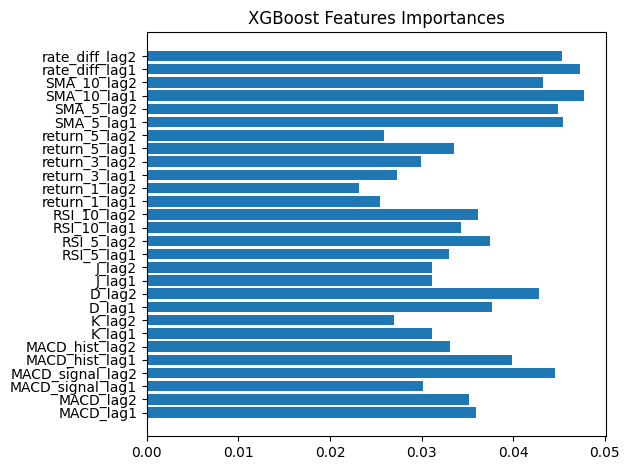

In [19]:
all_features = []
for col in lag_features:
    all_features += [f'{col}_lag1', f'{col}_lag2']

df_model = df.dropna(subset=all_features + ['trend_up_5d'])
X = df_model[all_features]
y = df_model['trend_up_5d']

# --- Step 4: 拆分训练集和测试集（时间序列，不shuffle）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Step 5: 训练 XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# --- Step 6: 预测与评估
y_pred = model.predict(X_test)
print(f'预测准确率: {accuracy_score(y_test, y_pred):.2%}')
print('混淆矩阵:\n', confusion_matrix(y_test, y_pred))
print('分类报告:\n', classification_report(y_test, y_pred))

# --- Step 7: 特征重要性图
importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.title('XGBoost Features Importances')
plt.tight_layout()
plt.show()

# --- （可选）输出上涨概率（0~1）
y_prob = model.predict_proba(X_test)[:, 1]
df_result = X_test.copy()
df_result['predicted_prob_up'] = y_prob
df_result['true_label'] = y_test.values
